# Text Classification:

## Data
<pre>
1. we have total of 20 types of documents(Text files) and total 18828 documents(text files).
2. You can download data from this <a href='https://drive.google.com/open?id=1rxD15nyeIPIAZ-J2VYPrDRZI66-TBWvM'>link</a>, in that you will get documents.rar folder. <br>If you unzip that, you will get total of 18828 documnets. document name is defined as'ClassLabel_DocumentNumberInThatLabel'. 
so from document name, you can extract the label for that document.
4. Now our problem is to classify all the documents into any one of the class.
5. Below we provided count plot of all the labels in our data. 
</pre>

#### sample document
<pre>
<font color='blue'>
Subject: A word of advice
From: jcopelan@nyx.cs.du.edu (The One and Only)

In article < 65882@mimsy.umd.edu > mangoe@cs.umd.edu (Charley Wingate) writes:
>
>I've said 100 times that there is no "alternative" that should think you
>might have caught on by now.  And there is no "alternative", but the point
>is, "rationality" isn't an alternative either.  The problems of metaphysical
>and religious knowledge are unsolvable-- or I should say, humans cannot
>solve them.

How does that saying go: Those who say it can't be done shouldn't interrupt
those who are doing it.

Jim
--
Have you washed your brain today?
</font>
</pre>

In [201]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import pickle
import re


from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


from keras.layers.convolutional import Conv1D
from keras.callbacks import TensorBoard,ModelCheckpoint

%reload_ext tensorboard
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,Input,Model
from keras.layers import Dense,MaxPooling1D
from keras.layers import Flatten,Dropout,concatenate
from keras.layers import Embedding
from sklearn.metrics import f1_score,roc_auc_score
from keras.callbacks import TensorBoard

In [202]:
import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\prana\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\prana\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\prana\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [203]:
class_label = []
content = []
document_name = []

for file in tqdm(os.listdir('documents/x/')):
    document_name.append(file)
    data = []
    label = file.split('_')[0]
    class_label.append(label)# here we are extracting class labels 
    
    with open('documents/x/'+file,'r',encoding='utf8',errors='replace') as file:
        data.append(file.read())
    content.append(data)

100%|██████████████████████████████████████████████████████████████████████████| 18828/18828 [00:04<00:00, 4287.85it/s]


In [204]:
len(document_name)

18828

In [205]:
data = pd.DataFrame(
    {'document_name': document_name,
     'doc_contents': content,
     'class_label':class_label
    })

In [206]:
len(data)

18828

In [207]:
data.head()

,document_name,doc_contents,class_label
0,alt.atheism_49960.txt,[From: mathew <mathew@mantis.co.uk>\nSubject: ...,alt.atheism
1,alt.atheism_51060.txt,[From: mathew <mathew@mantis.co.uk>\nSubject: ...,alt.atheism
2,alt.atheism_51119.txt,[From: I3150101@dbstu1.rz.tu-bs.de (Benedikt R...,alt.atheism
3,alt.atheism_51120.txt,[From: mathew <mathew@mantis.co.uk>\nSubject: ...,alt.atheism
4,alt.atheism_51121.txt,[From: strom@Watson.Ibm.Com (Rob Strom)\nSubje...,alt.atheism


In [208]:
data.to_csv('preprocessed_data_file.csv', index = False)

In [209]:
preprocessed_data = pd.read_csv('preprocessed_data_file.csv')
preprocessed_data.head(5)

,document_name,doc_contents,class_label
0,alt.atheism_49960.txt,['From: mathew <mathew@mantis.co.uk>\nSubject:...,alt.atheism
1,alt.atheism_51060.txt,['From: mathew <mathew@mantis.co.uk>\nSubject:...,alt.atheism
2,alt.atheism_51119.txt,['From: I3150101@dbstu1.rz.tu-bs.de (Benedikt ...,alt.atheism
3,alt.atheism_51120.txt,['From: mathew <mathew@mantis.co.uk>\nSubject:...,alt.atheism
4,alt.atheism_51121.txt,['From: strom@Watson.Ibm.Com (Rob Strom)\nSubj...,alt.atheism


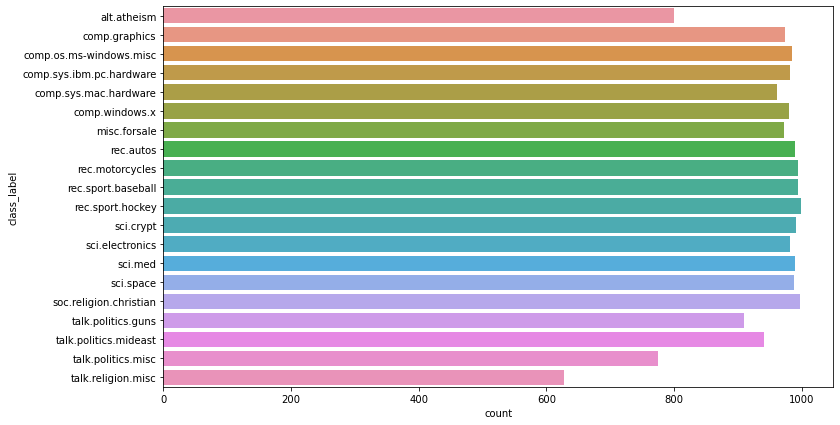

In [210]:
plt.figure(figsize=(12,7))
sns.countplot(y = preprocessed_data['class_label'])
plt.show()   # here we got fairly balanced data

### Preprocessing:
<pre>
useful links: <a href='http://www.pyregex.com/'>http://www.pyregex.com/</a>

<font color='blue'><b>1.</b></font> Find all emails in the document and then get the text after the "@". and then split those texts by '.' 
after that remove the words whose length is less than or equal to 2 and also remove'com' word and then combine those words by space. 
In one doc, if we have 2 or more mails, get all.
<b>Eg:[test@dm1.d.com, test2@dm2.dm3.com]-->[dm1.d.com, dm3.dm4.com]-->[dm1,d,com,dm2,dm3,com]-->[dm1,dm2,dm3]-->"dm1 dm2 dm3" </b> 
append all those into one list/array. ( This will give length of 18828 sentences i.e one list for each of the document). 
Some sample output was shown below. 

> In the above sample document there are emails [jcopelan@nyx.cs.du.edu, 65882@mimsy.umd.edu, mangoe@cs.umd.edu]

preprocessing:
[jcopelan@nyx.cs.du.edu, 65882@mimsy.umd.edu, mangoe@cs.umd.edu] ==> [nyx cs du edu mimsy umd edu cs umd edu] ==> 
[nyx edu mimsy umd edu umd edu]

<font color='blue'><b>2.</b></font> Replace all the emails by space in the original text. 
</pre>

### To get above mentioned data frame --> Try to Write Total Preprocessing steps in One Function Named Preprocess as below. 

In [211]:
def preprocess(input_content):
    """Do all the Preprocessing as shown above and
    return a tuple contain preprocess_email,preprocess_subject,preprocess_text for that Text_data"""
    
    email = []  # store contents of the email in list
    list_of_preproessed_emails = ""  # store contents of the email in string
    
    for em in re.findall(r'[\w\-\.]+@[\w\.-]+\b', input_content):  #extracting email 
        input_content = re.sub(em,'',input_content)
        
        email_temp =[]
        email_temp = em.split('@')[1]      #taking text after @
        email_temp = email_temp.split('.')      # a list containing words split by "."  

        if 'com' in email_temp:
            email_temp.remove('com')
 
        for k in email_temp:            # removing words less than 3
              if len(k)>2:
                  email.append(k)
    
    for i in email:            #joining all the words in a string
        list_of_preproessed_emails += i
        list_of_preproessed_emails += ' '
        
    subject = re.search(r'Subject:(.*?)\\n', input_content).group(1) 
    subject =  re.sub(r'\\t','',subject)  #finding the main text of sbject 
    input_content = re.sub(r'Subject:','',input_content)  # removing the Subject keyword

    input_content = re.sub(r'<(.*?)>','',input_content)    # removing tags like <,>
    input_content = re.sub(r'<','',input_content)
    input_content = re.sub(r'>','',input_content)
    
    input_content = re.sub(r'\((.*?)\)','',input_content)  # removing tags like (,)
    input_content = re.sub(r'\(','',input_content)
    input_content = re.sub(r'\)','',input_content)
    
    input_content = re.sub(r'Write to:(.*?)\\n','',input_content) # removing text after Write to: in a particular sentence 
    input_content = re.sub(r'Write to:','',input_content) # removing the Write to: keyword 
     
    input_content = re.sub(r'From:(.*?)\\n','',input_content) # removing text after From: in a particular sentence 
    input_content = re.sub(r'From:','',input_content)  # removing the From: keyword 
    
    input_content = input_content.replace('\\n','') # removing all the newlines('\n')
    input_content = input_content.replace('\\t','') # removing all the tabs('\t')
    input_content = input_content.replace('-','') # removing all the "-"
    input_content = input_content.replace('\\','') # removing all the "\"
    input_content = input_content.replace('/',' ') # removing all the "/"
    
    input_content = re.sub(r'\w+:\s?','',input_content)  # removing all the words which ends with ":"
    
    input_content = input_content.replace("won't", 'will not')  # Decontractions, replaceing words to their fullforms.
    input_content = input_content.replace("don't", 'do not')
    input_content = input_content.replace("'s", ' is')
    input_content = input_content.replace("'m",' am')
    input_content = input_content.replace("'re", ' are')
    input_content = input_content.replace("'ve", ' have')
    input_content = input_content.replace("n't", ' not')
    input_content = input_content.replace("'ll", ' will') 
    input_content = input_content.replace("should n't", 'should not')
    input_content = input_content.replace("can't", 'can not') 
    
    
    tree = nltk.ne_chunk(nltk.pos_tag(input_content.split()))  # TEXT chunking on the text
    
    GPE_arr=[]
    for tree in tree.subtrees(filter=lambda z: z.label() == 'GPE' ):
        for features in tree.leaves():
            (exp, label) = features
            if label == 'NNP':
                GPE_arr.append(exp)
                
    PERSON_arr=[]            
    for tree in tree.subtrees(filter=lambda z: z.label() == 'PERSON' ):
        for features in tree.leaves():
            (exp, label) = features
            if label =='NNP':
                PERSON_arr.append(exp)
                
                
    for person in PERSON_arr:
        input_content = input_content.replace(person,"")
        
    temp = '_'.join(GPE_arr)
    input_content = input_content.replace(temp,"")
    
    
    input_content = re.sub(r'[0-9]','',input_content)  # removing all the digits
    
    input_content = re.sub(re.compile(r'_+[a-zA-Z+]+_'),'',input_content) # removing all the words like _word_
    input_content = re.sub(re.compile(r'_+[a-zA-Z+]'),'',input_content) # removing all the words like _word
    input_content = re.sub(re.compile(r'[a-zA-Z+]+_'),'',input_content) # removing all the words like word_
    
    matches = re.findall(r'[a-zA-Z]+_+[a-zA-Z]+',input_content)   # words with underscore
    
    for match in matches:       # removing the words which are length less than or equal to 2
        arr = match.split('_')
        for i in arr:
            if len(i)<=2:
                arr.remove(i)
                arr = ' '.join(arr)
                input_content = input_content.replace(str(match),str(arr))
     
    input_content = input_content.lower()  # converting to lower case
    input_content=input_content.split(' ')
    
    for word in input_content:     # removing the words >= 15 or <= 2
        if (len(word)<3 or len(word)>15):
            input_content.remove(word)
    input_content = " ".join(input_content)
    input_content  = re.sub(re.compile(r'[^a-zA-Z_]'),' ',input_content)
   
    return (list_of_preproessed_emails,subject,input_content)

In [212]:
email_example,subject_example,Text_example = preprocess(np.array(preprocessed_data[preprocessed_data['document_name']=="alt.atheism_49960.txt"]['doc_contents'])[0])
print('Email:-',email_example,'\nSubject:-',subject_example,'\nText:-',Text_example)

Email:- mantis netcom mantis  
Subject:-  Alt.Atheism FAQ: Atheist Resources 
Text:- alt atheism atheist atheism december atheist resources addresses atheist organizations usafreedom from religion fish bumper stickers and assorted other atheist paraphernalia areavailable from the freedom from religion foundation the us  evolution designs sell the  darwin fish   fish symbol  like the oneschristians stick their cars  but with feet and the word  darwin  writteninside  the deluxe moulded plastic fish    postpaid the us   people the san francisco bay area can get darwin fish from lynn gold try mailing for net people who lynn directly  theprice    per fish american atheist pressaap publish various atheist books critiques the bible  lists ofbiblical contradictions  and on  one such book  the bible handbook  w p  ball and g w  foote  american atheist press  pp  isbn nd edition  bible atrocities  immoralities    contains ball   the itself   aap  based the king james version the bible  cameron r

### After writing Preprocess function, call the function for each of the document(18828 docs) and then create a dataframe as mentioned above.

In [213]:
preprocessed_text,preprocessed_subject,preprocessed_emails = [],[],[]

for i in tqdm(np.array(preprocessed_data['doc_contents'])):
    email,subject,text = preprocess(i)
    preprocessed_emails.append(email)
    preprocessed_subject.append(subject)
    preprocessed_text.append(text)

preprocessed_data['preprocessed_subject'] = preprocessed_subject
preprocessed_data['preprocessed_email'] = preprocessed_emails
preprocessed_data['preprocessed_text'] = preprocessed_text

preprocessed_data

100%|████████████████████████████████████████████████████████████████████████████| 18828/18828 [13:03<00:00, 24.03it/s]


,document_name,doc_contents,class_label,preprocessed_subject,preprocessed_email,preprocessed_text
0,alt.atheism_49960.txt,['From: mathew <mathew@mantis.co.uk>\nSubject:...,alt.atheism,Alt.Atheism FAQ: Atheist Resources,mantis netcom mantis,alt atheism atheist atheism december atheist r...
1,alt.atheism_51060.txt,['From: mathew <mathew@mantis.co.uk>\nSubject:...,alt.atheism,Alt.Atheism FAQ: Introduction to Atheism,mantis mantis mantis,alt atheism introduction atheism april begin ...
2,alt.atheism_51119.txt,['From: I3150101@dbstu1.rz.tu-bs.de (Benedikt ...,alt.atheism,Re: Gospel Dating,dbstu1 tu-bs mimsy umd edu umd edu,gospel datingin article well john has quite d...
3,alt.atheism_51120.txt,['From: mathew <mathew@mantis.co.uk>\nSubject:...,alt.atheism,Re: university violating separation of church...,mantis kepler unh edu,university violating separation church state ...
4,alt.atheism_51121.txt,['From: strom@Watson.Ibm.Com (Rob Strom)\nSubj...,alt.atheism,"Re: [soc.motss, et al.] ""Princeton axes match...",Watson Ibm Com harder ccr-p ida org harder ccr...,soc motss al princeton axes matching fund...
...,...,...,...,...,...,...
18823,talk.religion.misc_84564.txt,['From: sbuckley@fraser.sfu.ca (Stephen Buckle...,talk.religion.misc,Re: Religion and marriage,fraser sfu magnus acs ohio-state edu,religion and marriage was not sure this was th...
18824,talk.religion.misc_84565.txt,['From: bakerj@gtephx.UUCP (Jon Baker)\nSubjec...,talk.religion.misc,Re: A Message for you Mr. President: How do y...,gtephx UUCP ifi uio ifi uio ncratl AtlantaGA N...,message for you you know what happened in arti...
18825,talk.religion.misc_84568.txt,"[""From: pharvey@quack.kfu.com (Paul Harvey)\nS...",talk.religion.misc,Re: Why did they behave as they did (Waco--re...,quack kfu emx utexas edu emx utexas edu,why did they behave they did article if you w...
18826,talk.religion.misc_84569.txt,['From: <KEVXU@CUNYVM.BITNET>\nSubject: Re: In...,talk.religion.misc,Re: Info about New Age!,CUNYVM BITNET digi lonestar org digi lonestar ...,info about new age in article the danger antic...


### Training The models to Classify: 

<pre>
1. Combine "preprocessed_text", "preprocessed_subject", "preprocessed_emails" into one column. use that column to model. 

2. Now Split the data into Train and test. use 25% for test also do a stratify split. 

3. Analyze your text data and pad the sequnce if required. 
Sequnce length is not restricted, you can use anything of your choice. 
you need to give the reasoning

4. Do Tokenizer i.e convert text into numbers. please be careful while doing it. 
if you are using tf.keras "Tokenizer" API, it removes the <b>"_"</b>, but we need that.

5. code the model's ( Model-1, Model-2 ) as discussed below 
and try to optimize that models.  

6. For every model use predefined Glove vectors. 
<b>Don't train any word vectors while Training the model.</b>

7. Use "categorical_crossentropy" as Loss. 

8. Use <b>Accuracy and Micro Avgeraged F1 score</b> as your as Key metrics to evaluate your model. 

9.  Use Tensorboard to plot the loss and Metrics based on the epoches.

10. Please save your best model weights in to <b>'best_model_L.h5' ( L = 1 or 2 )</b>. 

11. You are free to choose any Activation function, learning rate, optimizer.
But have to use the same architecture which we are giving below.

12. You can add some layer to our architecture but you <b>deletion</b> of layer is not acceptable.

13. Try to use <b>Early Stopping</b> technique or any of the callback techniques that you did in the previous assignments.

14. For Every model save your model to image ( Plot the model) with shapes 
and inlcude those images in the notebook markdown cell, 
upload those imgages to Classroom. You can use "plot_model" 
please refer <a href='https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model'>this</a> if you don't know how to plot the model with shapes. 

</pre>

1. Combine "preprocessed_text", "preprocessed_subject", "preprocessed_emails" into one column. use that column to model. 

In [214]:
preprocessed_data['preprocessed_data'] = preprocessed_data['preprocessed_subject']+' ' + preprocessed_data['preprocessed_email']+ ' ' +preprocessed_data['preprocessed_text']
preprocessed_data.to_csv('preprocessed_data_file2.csv', index = False)

In [215]:
preprocessed_data_file2 = pd.read_csv('preprocessed_data_file2.csv')
preprocessed_data_file2.head(5)

,document_name,doc_contents,class_label,preprocessed_subject,preprocessed_email,preprocessed_text,preprocessed_data
0,alt.atheism_49960.txt,['From: mathew <mathew@mantis.co.uk>\nSubject:...,alt.atheism,Alt.Atheism FAQ: Atheist Resources,mantis netcom mantis,alt atheism atheist atheism december atheist r...,Alt.Atheism FAQ: Atheist Resources mantis net...
1,alt.atheism_51060.txt,['From: mathew <mathew@mantis.co.uk>\nSubject:...,alt.atheism,Alt.Atheism FAQ: Introduction to Atheism,mantis mantis mantis,alt atheism introduction atheism april begin ...,Alt.Atheism FAQ: Introduction to Atheism mant...
2,alt.atheism_51119.txt,['From: I3150101@dbstu1.rz.tu-bs.de (Benedikt ...,alt.atheism,Re: Gospel Dating,dbstu1 tu-bs mimsy umd edu umd edu,gospel datingin article well john has quite d...,Re: Gospel Dating dbstu1 tu-bs mimsy umd edu ...
3,alt.atheism_51120.txt,['From: mathew <mathew@mantis.co.uk>\nSubject:...,alt.atheism,Re: university violating separation of church...,mantis kepler unh edu,university violating separation church state ...,Re: university violating separation of church...
4,alt.atheism_51121.txt,['From: strom@Watson.Ibm.Com (Rob Strom)\nSubj...,alt.atheism,"Re: [soc.motss, et al.] ""Princeton axes match...",Watson Ibm Com harder ccr-p ida org harder ccr...,soc motss al princeton axes matching fund...,"Re: [soc.motss, et al.] ""Princeton axes match..."


2. Now Split the data into Train and test. use 25% for test also do a stratify split. 

In [216]:
from sklearn.model_selection import train_test_split

y = preprocessed_data_file2['class_label'].values
x = preprocessed_data_file2.drop(['class_label'], axis=1)

In [217]:
X_train,X_test,y_train,y_test= train_test_split(x,y,random_state=42,stratify=y,test_size=0.25)

In [218]:
X_train.head(2)

,document_name,doc_contents,preprocessed_subject,preprocessed_email,preprocessed_text,preprocessed_data
16428,talk.politics.guns_55233.txt,['From: wwarf@silver.ucs.indiana.edu (Wayne J....,"Re: Your Evil Tax Dollars at Work, was RE: AT...",silver ucs indiana edu psuvm psu edu psuvm psu...,your evil tax dollars work was atf burns ranc...,"Re: Your Evil Tax Dollars at Work, was RE: AT..."
10459,rec.sport.hockey_54284.txt,['From: drozinst@db.erau.edu (Drozinski Tim)\n...,Re: Ulf and all...,erau edu philabs philips alpha erau edu erau e...,ulf and all in article an ulf fan and what...,Re: Ulf and all... erau edu philabs philips a...


3. Analyze your text data and pad the sequnce if required. 
Sequnce length is not restricted, you can use anything of your choice. 
you need to give the reasoning.

4. Do Tokenizer i.e convert text into numbers. please be careful while doing it. 
if you are using tf.keras "Tokenizer" API, it removes the <b>"_"</b>, but we need that.

In [219]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

Y_train_label = tf.keras.utils.to_categorical(LabelEncoder().fit_transform(y_train), 20)
print('Y Train shape :- ',Y_train_label.shape)

Y_test_label = tf.keras.utils.to_categorical(LabelEncoder().fit_transform(y_test), 20)
print('Y Test shape :- ',Y_test_label.shape)                                                                                                                                                                      

Y Train shape :-  (14121, 20)
Y Test shape :-  (4707, 20)


In [220]:
Y_train_label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [223]:
np.random.seed(42)

token = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^`{|}~\t\n')   # we are not mentioning '_' here.
token.fit_on_texts(X_train['preprocessed_data'])

vocab_size = len(token.word_index) + 1

encoded_docs_train= token.texts_to_sequences(X_train['preprocessed_data'])
encoded_docs_test= token.texts_to_sequences(X_test['preprocessed_data'])

In [224]:
vocab_size

145865

In [225]:
max_length_for_padding=[] 
for i in encoded_docs_train:  
    max_length_for_padding.append(len(i))  
    
max_len = max(max_length_for_padding)

padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_len, padding='post')
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_len, padding='post')

6. For every model use predefined Glove vectors. 
Don't train any word vectors while Training the model.

In [226]:
embeddings_index = dict()

file = open('glove.6B.100d.txt',encoding="utf8")
for line in file:
    word = line.split()[0]
    coef = np.asarray(line.split()[1:], dtype='float32')
    embeddings_index[word] = coef
file.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [227]:
embedding_matrix = np.zeros((vocab_size, 100))

for word, i in token.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

7. Use "categorical_crossentropy" as Loss. 

8. Use Accuracy and Micro Avgeraged F1 score as your as Key metrics to evaluate your model. 

In [228]:
%reload_ext tensorboard

log_dir = "documents/logs" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensor = TensorBoard(log_dir='documents/logs',histogram_freq=1,write_graph=True)

class F1_score(tf.keras.callbacks.Callback):
    
    def __init__(self,validation_data):
        self.validation_data = validation_data 

    def on_train_begin(self, logs={}):
        self.f1 = []
        self.aucs = []
        
    def on_epoch_end(self, epoch, logs={}):    
        predicted = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        target    = self.validation_data[1]
        f1_values     = f1_score(target, predicted, average='micro')
        auc_values    = roc_auc_score(target, predicted)
        
        self.f1.append(f1_values)
        self.aucs.append(auc_values)
        
        print(' AUC = {0} and F1 Score = {1}'.format(auc_values,f1_values))

In [229]:
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint = ModelCheckpoint(filepath = 'best_model_weights/best_model_L.h5', monitor ='accuracy' ,mode='auto', save_best_only = True , verbose=2) 

<pre>
5. code the model's ( Model-1, Model-2 ) as discussed below 
and try to optimize that models.  

6. For every model use predefined Glove vectors. 
<b>Don't train any word vectors while Training the model.</b>

7. Use "categorical_crossentropy" as Loss. 

8. Use <b>Accuracy and Micro Avgeraged F1 score</b> as your as Key metrics to evaluate your model. 

9.  Use Tensorboard to plot the loss and Metrics based on the epoches.

10. Please save your best model weights in to <b>'best_model_L.h5' ( L = 1 or 2 )</b>. 

11. You are free to choose any Activation function, learning rate, optimizer.
But have to use the same architecture which we are giving below.

12. You can add some layer to our architecture but you <b>deletion</b> of layer is not acceptable.

13. Try to use <b>Early Stopping</b> technique or any of the callback techniques that you did in the previous assignments.

14. For Every model save your model to image ( Plot the model) with shapes 
and inlcude those images in the notebook markdown cell, 
upload those imgages to Classroom. You can use "plot_model" 
please refer <a href='https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model'>this</a> if you don't know how to plot the model with shapes. 
</pre>

### Model-1: Using 1D convolutions with word embeddings

In [237]:
# input_text: InputLayers
inputLayers =  Input(shape=(max_len,),dtype='int32')

# embedding: Embedding
emd = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_len, trainable=True)(inputLayers)

# three layers of Conv1D with filter size 
x1 = Conv1D(13,17,  kernel_initializer=tf.keras.initializers.HeUniform(), activation='relu')(emd)
x2 = Conv1D(13,18,  kernel_initializer=tf.keras.initializers.HeUniform(), activation='relu')(emd)
x3 = Conv1D(13,16,  kernel_initializer=tf.keras.initializers.HeUniform(), activation='relu')(emd)

# concatenate1: Concatenate_above_three_layers: concatenate
concatenated_layer1 = concatenate([x1,x2,x3],axis=1)

# max_poolLayer1 : MaxPooling1D
max_pool1 = MaxPooling1D(3)(concatenated_layer1)

# Conv1D with filter size 9,4,5
x4=Conv1D(12,19,kernel_initializer=tf.keras.initializers.HeUniform(),activation='relu')(max_pool1)
x5=Conv1D(12,14,kernel_initializer=tf.keras.initializers.HeUniform(),activation='relu')(max_pool1)
x6=Conv1D(12,15,kernel_initializer=tf.keras.initializers.HeUniform(),activation='relu')(max_pool1)

# concatenate2: Concatenate_above_three_layers: concatenate
concatenated_layer2 =concatenate([x4,x5,x6],axis=1)

# max_poolLayer2 : MaxPooling1D
max_pool2 = MaxPooling1D(3)(concatenated_layer2)

# Dropout: dropout
drop_out1=Dropout(0.25)(max_pool2)

max_pool3=MaxPooling1D(3)(drop_out1)

x7=Conv1D(15,12,kernel_initializer=tf.keras.initializers.HeUniform() ,activation='relu')(max_pool3)
x8=Conv1D(15,12,kernel_initializer=tf.keras.initializers.HeUniform() ,activation='relu')(max_pool3)

concatenated_layer3 =concatenate([x7,x8],axis=1)
flatten=Flatten()(concatenated_layer3)

# Dropout: dropout
drop_out2=Dropout(0.25)(flatten)

# Dense1 : Dense
dense_layer1=Dense(124, activation='relu')(drop_out2)
outputLayer=Dense(20, activation='softmax')(dense_layer1)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
early_stopping = EarlyStopping(monitor='accuracy', min_delta=0.001, patience=2, verbose=1)
score=F1_score(validation_data=(padded_docs_test,Y_test_label))

# OutputLayer : Dense
model = Model(inputs=inputLayers,outputs=outputLayer)
# compile the model

history=model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 8647)]       0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 8647, 100)    14586500    input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_78 (Conv1D)              (None, 8631, 13)     22113       embedding_12[0][0]               
__________________________________________________________________________________________________
conv1d_79 (Conv1D)              (None, 8630, 13)     23413       embedding_12[0][0]               
______________________________________________________________________________________

In [238]:
model.fit(padded_docs_train, Y_train_label,validation_split=0.25, epochs=10, verbose=1,callbacks=[tensor,early_stopping,score,checkpoint])

Epoch 1/10
331/331 [==============================] - ETA: 0s - loss: 2.2641 - accuracy: 0.2523 AUC = 0.5874998871616883 and F1 Score = 0.29850746268656714

Epoch 00001: accuracy did not improve from 0.42872
331/331 [==============================] - 1166s 4s/step - loss: 2.2641 - accuracy: 0.2523 - val_loss: 1.6400 - val_accuracy: 0.4449
Epoch 2/10
331/331 [==============================] - ETA: 0s - loss: 1.0788 - accuracy: 0.6245 AUC = 0.763603551647611 and F1 Score = 0.6625194401244168

Epoch 00002: accuracy improved from 0.42872 to 0.62446, saving model to best_model_weights\best_model_L.h5
331/331 [==============================] - 1158s 3s/step - loss: 1.0788 - accuracy: 0.6245 - val_loss: 0.9134 - val_accuracy: 0.7114
Epoch 3/10
331/331 [==============================] - ETA: 0s - loss: 0.5166 - accuracy: 0.8229 AUC = 0.8155489902777248 and F1 Score = 0.7310311865216872

Epoch 00003: accuracy improved from 0.62446 to 0.82295, saving model to best_model_weights\best_model_L.h5
3

In [239]:
loss, accuracy = model.evaluate(padded_docs_test, Y_test_label)

148/148 [==============================] - 31s 206ms/step - loss: 1.3573 - accuracy: 0.7434


In [240]:
accuracy * 100

74.33609366416931

### Model-2 : Using 1D convolutions with character embedding

<pre>
<pre><img src="https://i.ytimg.com/vi/CNY8VjJt-iQ/maxresdefault.jpg" width="70%">
Here are the some papers based on Char-CNN
 1. Xiang Zhang, Junbo Zhao, Yann LeCun. <a href="http://arxiv.org/abs/1509.01626">Character-level Convolutional Networks for Text Classification</a>.NIPS 2015
 2. Yoon Kim, Yacine Jernite, David Sontag, Alexander M. Rush. <a href="https://arxiv.org/abs/1508.06615">Character-Aware Neural Language Models</a>. AAAI 2016
 3. Shaojie Bai, J. Zico Kolter, Vladlen Koltun. <a href="https://arxiv.org/pdf/1803.01271.pdf">An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling</a>
 4. Use the pratrained char embeddings <a href='https://github.com/minimaxir/char-embeddings/blob/master/glove.840B.300d-char.txt'>https://github.com/minimaxir/char-embeddings/blob/master/glove.840B.300d-char.txt</a>
</pre>

In [140]:
np.random.seed(42)

token = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^`{|}~\t\n',char_level=True,lower=True,num_words=10000)   # we are not mentioning '_' here.
token.fit_on_texts(X_train['preprocessed_data'])

vocab_size = len(token.word_index) + 1

encoded_docs_train= token.texts_to_sequences(X_train['preprocessed_data'])
encoded_docs_test= token.texts_to_sequences(X_test['preprocessed_data'])

In [142]:
max_length_for_padding=[] 
for i in encoded_docs_train:  
    max_length_for_padding.append(len(i))  
    
max_len = max(max_length_for_padding)

padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_len, padding='post')
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_len, padding='post')

In [143]:
embeddings_index = dict()

file = open('glove.840B.300d-char.txt')
for line in file:
    word = line.split()[0]
    coef = np.asarray(line.split()[1:], dtype='float32')
    embeddings_index[word] = coef
file.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 94 word vectors.


In [144]:
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in token.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [145]:
inputLayers =  Input(shape=(max_len,),dtype='int32')

# embedding: Embedding layer to get Char 
emd = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=True)(inputLayers)

# Conv1D with filter size 36,24
f1 = Conv1D(filters = 36, kernel_size= 16, activation='relu')(emd)
f2 = Conv1D(filters = 24, kernel_size= 12, activation='relu')(f1)

mp1 = MaxPooling1D(pool_size=2)(f2)

# Conv1D with filter size 32,16
f3 = Conv1D(filters = 32, kernel_size= 16, activation='relu')(mp1)
f4 = Conv1D(filters = 16, kernel_size= 12, activation='relu')(f3)   
mp2 = MaxPooling1D(pool_size=2)(f4)

# Conv1D with filter size 28,18
f5 = Conv1D(filters = 28, kernel_size= 8, activation='relu')(mp2)
f6 = Conv1D(filters = 18, kernel_size= 4, activation='relu')(f5)

mp3 = MaxPooling1D(pool_size=2)(f6)
flat1 = Flatten()(mp3)

# Dense1 : Dense
d1 = Dense(8,activation ='relu')(flat1)
d2 = Dense(32,activation ='relu')(d1)

# Dropout: dropout
drop1 = Dropout(0.20)(d2)

# Dense2 : Dense
d3 = Dense(128,activation ='relu')(drop1)
d4 = Dense(256,activation ='relu')(d3)

# Dropout2: dropout
drop2 = Dropout(0.20)(d4)

# Dense3 : Dense
d5 = Dense(128,activation ='relu')(drop2)

# OutputLayer
outputLayer = Dense(20, activation ='softmax')(d5)

model = Model(inputs = inputLayers,outputs = outputLayer)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
earlystopping = EarlyStopping(monitor='accuracy', min_delta=0.005, patience=2, verbose=1)
score=F1_score(validation_data=(padded_docs_test,Y_test_label))

# compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 56440)]           0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 56440, 300)        21300     
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 56425, 36)         172836    
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 56414, 24)         10392     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 28207, 24)         0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 28192, 32)         12320     
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 28181, 16)       

In [146]:
model.fit(padded_docs_train, Y_train_label, epochs=10, verbose=1,callbacks=[tensor,earlystopping,score,checkpoint])

Epoch 1/10
442/442 [==============================] - ETA: 0s - loss: 2.9654 - accuracy: 0.0696  AUC = 0.5 and F1 Score = 0.0

Epoch 00001: accuracy improved from -inf to 0.06961, saving model to best_model_weights\best_model_L.h5
442/442 [==============================] - 8594s 19s/step - loss: 2.9654 - accuracy: 0.0696
Epoch 2/10
442/442 [==============================] - ETA: 0s - loss: 2.9312 - accuracy: 0.0814  AUC = 0.5 and F1 Score = 0.0

Epoch 00002: accuracy improved from 0.06961 to 0.08144, saving model to best_model_weights\best_model_L.h5
442/442 [==============================] - 8546s 19s/step - loss: 2.9312 - accuracy: 0.0814
Epoch 3/10
442/442 [==============================] - ETA: 0s - loss: 2.9210 - accuracy: 0.0836  AUC = 0.5 and F1 Score = 0.0

Epoch 00003: accuracy improved from 0.08144 to 0.08356, saving model to best_model_weights\best_model_L.h5
442/442 [==============================] - 8548s 19s/step - loss: 2.9210 - accuracy: 0.0836
Epoch 4/10
442/442 [=====

In [147]:
loss, accuracy = model.evaluate(padded_docs_test, Y_test_label)

148/148 [==============================] - 353s 2s/step - loss: 2.9106 - accuracy: 0.0884


In [175]:
accuracy*100

8.837901055812836

## Conclusion

1. Difference between Character Embedding and Word Embedding is that Character Embedding can build any word as long as those character are included.
2. There are about 71 English-language characters in common usage if we include all punctuation marks. By contrast, a vocabulary is many thousands of words. Beacuse of this, Word Embedding(model 1) works better than character Embedding(Model 2)
